# FDSolverPy Demo
This notebook briefly demonstrates how to run a microstructure diffusion calculation with `FDSolverPy`, a finite-difference solver. In general, to run a calculation requires three things:

- Grid
- diffusivity field $d(\mathbf{r})$
- Initial concentration $C_0$, whose edge values also define the boundary condition applied (in the case of non-pbc calculations)


## 1. microstructure calculation in 2D
First, let's take a microstructure from file

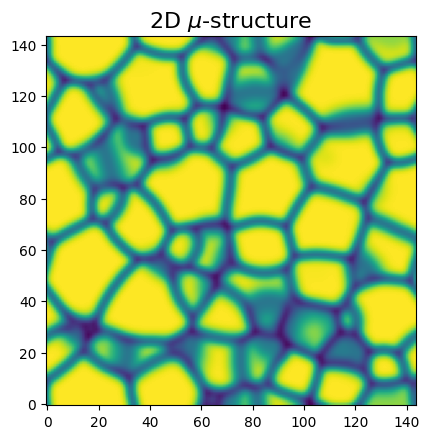

In [1]:
#- import libraries
import numpy as np
import os
from FDSolverPy.diffusion.DiffSolver import *
from FDSolverPy.math.space import Grid
from FDSolverPy.tools.plot_scripts import *
import matplotlib.pyplot as py
%matplotlib inline

#- extract a 2d slice of microstructure for this problem
locals().update(np.load('../../microstruct.npz'))
gphi = gphi[:,:,0]

#- plotting
fig,ax = py.subplots()
ax.imshow(gphi.T,origin='lower')
ax.set_title(r'2D $\mu$-structure',fontsize=16)
py.show()

### 1.i writing inputs
Now let's write the inputs to file. We define the bulk/GB diffusivities to be $10^{-8}$ / $10^{-4}$ respectively. Also, we apply a concentration gradient $Q=[1,0]$ here.

In [2]:
#- build inputs

# 1. Grid
ns,Ls = ns[:2], Ls[:2]
gd = Grid(ns=ns,Ls=Ls)

# 2. diffusivity
db, dgb = np.eye(2)*1e-8, np.eye(2)*1e-4
d = np.einsum('ab,ij->abij',gphi,db)+\
    np.einsum('ab,ij->abij',1-gphi,dgb)

# 3. Initial profile
Q = np.array([1,0])
C0 = macro_C0(gd,Q)

# write inputs to file
write_inputs(f'./2d/Q_0',{'GD':gd},C0,d)

Created input files at ./2d/Q_0


### 1.ii run calculation

In [3]:
#- initialize calculator
cwd = os.getcwd()
os.chdir('2d/Q_0')
calc = diff_solver(**read_diffsolver_args())

#- normalize parameters for better numerical stability
d_mean, F_max = normalize_parameters(calc)

#- Calculate!
calc.run(etol=1e-5,ftol=F_max*1e-2,Nstep=400,step=50)
os.chdir(cwd)

Running on 1 cores
Domain decomposition1x1

normalized diffusivity d by 2.959290274115453e-05, with F_max:1.95105652579581
run parameters

start from scratch

etol: 1.0000e-05  ftol: 1.9511e-02

line search args: {'t0': 0.01, 'tol': 1e-05}

Nstep: 400  step: 50  clean_old: True

Big Loop Begins...
it(#)     F(eV)                    Force_max(eV/A)     Time(h:m:s)    
0         1.036800000000e+04       1.9511e+00          0:00:00.000026 
50        7.294931798883e+03       4.7768e-01          0:00:03.544795 
100       7.236988632414e+03       2.9365e-01          0:00:06.990793 
150       7.228322782900e+03       9.0421e-02          0:00:10.548578 
200       7.226126350823e+03       3.8346e-02          0:00:14.036208 
250       7.225466249725e+03       3.1262e-02          0:00:17.580652 
254       7.225429536814e+03       1.9347e-02          0:00:17.958777 
Big Loop time lapse: 0:00:17.959003



To calculate the effective diffusivity requires a second calculation with a different gradient $Q$ applied. We can repeat similar steps for $Q=[0,1]$ below.

In [4]:
# 3. Initial profile
Q = np.array([0,1])
C0 = macro_C0(gd,Q)

# write inputs to file
write_inputs(f'2d/Q_1',{'GD':gd},C0,d)

#- initialize calculator
cwd = os.getcwd()
os.chdir('2d/Q_1')
calc = diff_solver(**read_diffsolver_args())

#- normalize parameters for better numerical stability
d_mean, F_max = normalize_parameters(calc)

#- Calculate!
calc.run(etol=1e-5,ftol=F_max*1e-2,Nstep=400,step=50)
os.chdir(cwd)

Created input files at 2d/Q_1
Running on 1 cores
Domain decomposition1x1

normalized diffusivity d by 2.959290274115453e-05, with F_max:1.9509592519013075
run parameters

start from scratch

etol: 1.0000e-05  ftol: 1.9510e-02

line search args: {'t0': 0.01, 'tol': 1e-05}

Nstep: 400  step: 50  clean_old: True

Big Loop Begins...
it(#)     F(eV)                    Force_max(eV/A)     Time(h:m:s)    
0         1.036800000000e+04       1.9510e+00          0:00:00.000034 
50        6.581478244674e+03       8.5514e-01          0:00:03.500705 
100       6.445747908991e+03       4.0118e-01          0:00:06.927570 
150       6.430168352485e+03       1.2117e-01          0:00:10.223017 
200       6.426212872678e+03       4.1437e-02          0:00:13.650339 
250       6.425149436344e+03       2.2798e-02          0:00:17.048319 
291       6.424611133710e+03       1.7748e-02          0:00:19.893718 
Big Loop time lapse: 0:00:19.893956



### 1.iii Visualization and effective properties

[[ 2.06769478e-05 -2.03247237e-07]
 [-1.98678327e-07  1.83783039e-05]]
Reading the 254th frame...
Running on 1 cores
Domain decomposition1x1

Reading the 291th frame...
Running on 1 cores
Domain decomposition1x1



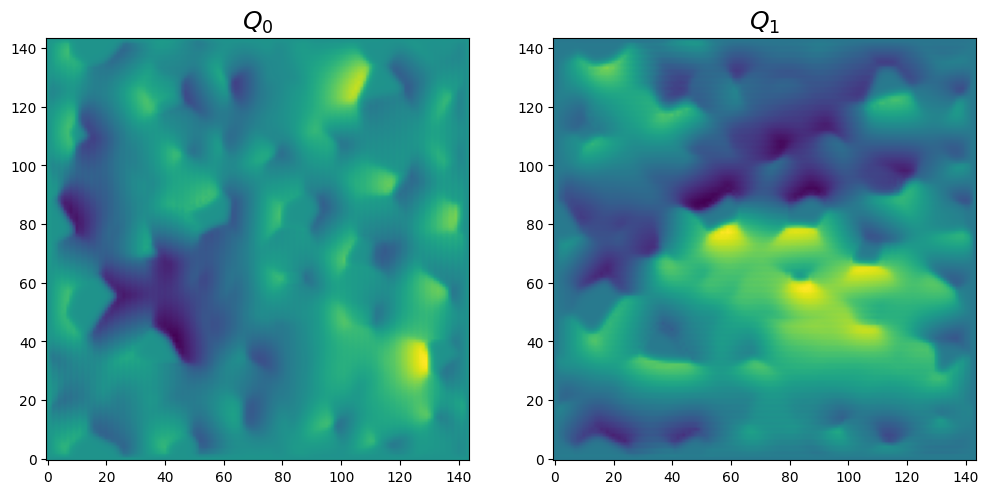

In [3]:
#- D_eff
cwd=os.getcwd()
os.chdir('2d')
D = calculate_D(['Q_0','Q_1'])
print(np.array(D['Ds']))
os.chdir(cwd)

#- visualization
fig,axs = py.subplots(1,2,figsize=(12,6))
Qs = np.eye(2)
for i in range(2):
    calc, c, q, j = read_diffsolver(f'2d/Q_{i}')
    C0 = macro_C0(gd,Qs[i])
    del_c = c-C0
    axs[i].imshow((del_c).T,origin='lower')
    axs[i].set_title(rf'$Q_{i}$',fontsize=18)

## 2. Microstructure calculation in 3D
Now that we learned the basics, we can run a 3D microstructure calculation for its effective diffusivity. 
### 2.i write inputs
we will use a function `write_d_eff_inputs` to quickly write all three inputs required to calculate effective diffusivity of a 3D microstructure

Created input files at 3d/Q_0
Created input files at 3d/Q_1
Created input files at 3d/Q_2


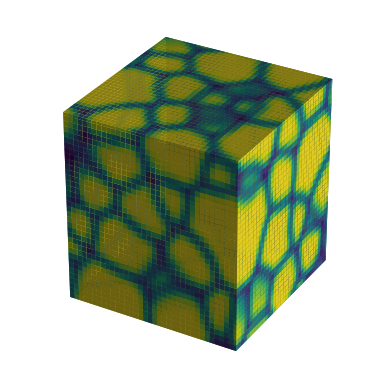

In [5]:
# define grid
locals().update(np.load('../../microstruct.npz'))
n = 72
gphi = gphi[:n,:n,:n]
ns = [n,n,n]
gd = Grid(ns=ns,Ls=Ls)

# define diffusivity
db, dgb = np.eye(3)*1, np.eye(3)*10
d = np.einsum('...,ij->...ij',gphi,db)+\
    np.einsum('...,ij->...ij',1-gphi,dgb)

# write inputs
write_d_eff_inputs('3d',d,gd)

# plotting
ax,plots = draw_cuboid(np.meshgrid(*gd.xs,indexing='ij'),gphi,plotter='matplotlib')
ax.axis('off')
py.show()

### 2.ii run calculation

In [3]:
cwd = os.getcwd()
for i in range(3):
    #- initialize calculator
    os.chdir(f'3d/Q_{i}')
    calc = diff_solver(**read_diffsolver_args())

    # normaliza parameters for better numerical stability
    d_mean, F_max = normalize_parameters(calc)
    
    #- Calculate!
    calc.run(etol=1e-5,ftol=F_max*1e-2,Nstep=150,step=50)
    os.chdir(cwd)

Running on 1 cores
Domain decomposition1x1x1

normalized diffusivity d by 3.751631559949177, with F_max:0.7987771299952571
run parameters

start from scratch

etol: 1.0000e-05  ftol: 7.9878e-03

line search args: {'t0': 0.01, 'tol': 1e-05}

Nstep: 150  step: 50  clean_old: True

Big Loop Begins...
it(#)     F(eV)                    Force_max(eV/A)     Time(h:m:s)    
0         1.492992000000e+06       7.9878e-01          0:00:00.000038 
50        1.357861884389e+06       1.4780e-01          0:00:40.348161 
100       1.357784727980e+06       3.2482e-02          0:01:19.983617 
110       1.357784187999e+06       6.5727e-03          0:01:31.140398 
Big Loop time lapse: 0:01:31.140685

Running on 1 cores
Domain decomposition1x1x1

normalized diffusivity d by 3.751631559949177, with F_max:0.8160074406995631
run parameters

start from scratch

etol: 1.0000e-05  ftol: 8.1601e-03

line search args: {'t0': 0.01, 'tol': 1e-05}

Nstep: 150  step: 50  clean_old: True

Big Loop Begins...
it(#)     

### 2.iii Visualization and effective properties

[[ 3.42999108  0.0127814   0.00603058]
 [ 0.01304534  3.42730785 -0.00404691]
 [ 0.00612839 -0.00418313  3.42781153]]
Reading the 110th frame...
Running on 1 cores
Domain decomposition1x1x1

Reading the 105th frame...
Running on 1 cores
Domain decomposition1x1x1

Reading the 102th frame...
Running on 1 cores
Domain decomposition1x1x1



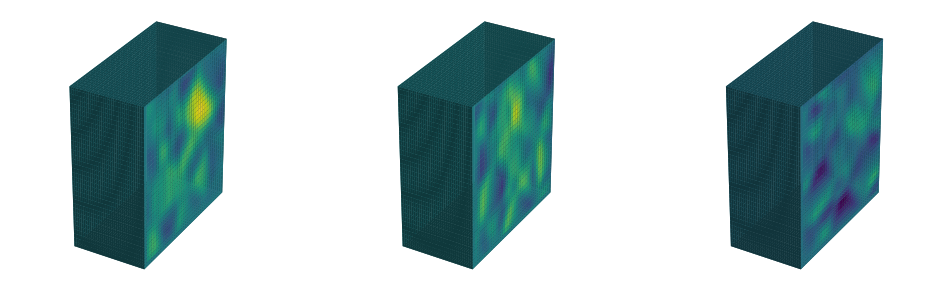

In [6]:
#- D_eff
cwd=os.getcwd()
os.chdir('3d')
D = calculate_D(['Q_0','Q_1','Q_2'])
print(np.array(D['Ds']))
os.chdir(cwd)

#- visualization
fig,axs = py.subplots(1,3,figsize=(12,6),subplot_kw=dict(projection='3d'))
Qs = np.eye(3)
for i in range(3):
    calc, c, q, j = read_diffsolver(f'3d/Q_{i}')
    C0 = macro_C0(gd,Qs[i])
    del_c = c - C0

    # plotting
    xxs = [xx[:36,:,:] for xx in calc.xxs]
    draw_cuboid(xxs,del_c[:36,:,:],fig,axs[i],plotter='matplotlib')
    axs[i].axis('off')
